In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.3)
train_dataset=train_datagen.flow_from_directory(directory='/content/drive/MyDrive/data/train/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                batch_size=64)
validation_dataset=train_datagen.flow_from_directory(directory='/content/drive/MyDrive/data/train/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True,
                                                batch_size=64)

test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_dataset=test_datagen.flow_from_directory(directory='/content/drive/MyDrive/data/test/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=False,
                                                batch_size=64)

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


In [4]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model DenseNet121
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [5]:
for layer in base_model.layers:
  layer.trainable=False

for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 zero_padding2d - False
2 conv1/conv - False
3 conv1/bn - False
4 conv1/relu - False
5 zero_padding2d_1 - False
6 pool1 - False
7 conv2_block1_0_bn - False
8 conv2_block1_0_relu - False
9 conv2_block1_1_conv - False
10 conv2_block1_1_bn - False
11 conv2_block1_1_relu - False
12 conv2_block1_2_conv - False
13 conv2_block1_concat - False
14 conv2_block2_0_bn - False
15 conv2_block2_0_relu - False
16 conv2_block2_1_conv - False
17 conv2_block2_1_bn - False
18 conv2_block2_1_relu - False
19 conv2_block2_2_conv - False
20 conv2_block2_concat - False
21 conv2_block3_0_bn - False
22 conv2_block3_0_relu - False
23 conv2_block3_1_conv - False
24 conv2_block3_1_bn - False
25 conv2_block3_1_relu - False
26 conv2_block3_2_conv - False
27 conv2_block3_concat - False
28 conv2_block4_0_bn - False
29 conv2_block4_0_relu - False
30 conv2_block4_1_conv - False
31 conv2_block4_1_bn - False
32 conv2_block4_1_relu - False
33 conv2_block4_2_conv - False
34 conv2_block4_concat - False
35 c

In [6]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')

In [7]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',keras.metrics.Recall(name='recall'),keras.metrics.Precision(name='precision'),f1_score, keras.metrics.AUC(name='auc')])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                                 
Total params: 7,058,004
Trainable params: 20,500
Non-trainable params: 7,037,504
_________________________________________________________________


In [10]:
validation_steps=150
initial_epochs = 150

In [11]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    filepath='/content/drive/MyDrive/data/densenet121.hdf5',
    save_best_only=True,
    mode='max',
    verbose=1
    )

In [12]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,verbose=1,callbacks=[model_checkpoint_callback],shuffle=True)

Epoch 1/150


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


110/110 [==============================] - ETA: 0s - loss: 2.9483 - accuracy: 0.1113 - recall: 2.8571e-04 - precision: 0.2000 - f1_score: 5.5944e-04 - auc: 0.6225 
Epoch 1: val_accuracy improved from -inf to 0.20233, saving model to /content/drive/MyDrive/data/densenet121.hdf5
110/110 [==============================] - 3050s 28s/step - loss: 2.9483 - accuracy: 0.1113 - recall: 2.8571e-04 - precision: 0.2000 - f1_score: 5.5944e-04 - auc: 0.6225 - val_loss: 2.6302 - val_accuracy: 0.2023 - val_recall: 6.6667e-04 - val_precision: 0.1000 - val_f1_score: 0.0013 - val_auc: 0.7514
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 2.4480 - accuracy: 0.2686 - recall: 0.0030 - precision: 0.5000 - f1_score: 0.0063 - auc: 0.8230
Epoch 2: val_accuracy improved from 0.20233 to 0.35967, saving model to /content/drive/MyDrive/data/densenet121.hdf5
110/110 [==============================] - 24s 214ms/step - loss: 2.4480 - accuracy: 0.2686 - recall: 0.0030 - precision: 0.5000 - f1_sc

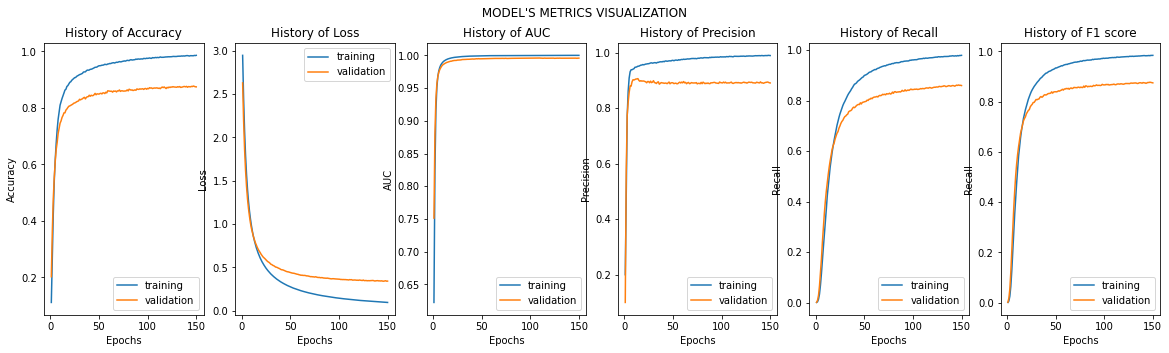

In [13]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [17]:
model.save("/content/drive/MyDrive/data/densenet121.hdf5")

name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = keras.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
        if str(layer) != name_seclast_layer:
            model2.add(layer)
        
model2.summary()    

model2.save('/content/drive/MyDrive/data/densenet121_mod.hdf5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [21]:
model = keras.models.load_model("/content/drive/MyDrive/data/densenet121.hdf5", custom_objects={"f1_score": f1_score })
model.evaluate(test_dataset)

/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 8s 151ms/step - loss: 0.3803 - accuracy: 0.8810 - recall: 0.8655 - precision: 0.8909 - f1_score: 0.8789 - auc: 0.9934


[0.38030558824539185,
 0.8809999823570251,
 0.8654999732971191,
 0.89089035987854,
 0.878935694694519,
 0.9934215545654297]

<ipython-input-22-76787b75b307>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


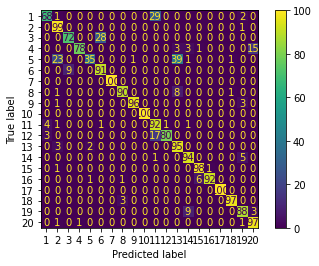

Classification Report
              precision    recall  f1-score   support

           1       0.91      0.68      0.78       100
           2       0.76      0.99      0.86       100
           3       0.89      0.72      0.80       100
           4       0.99      0.78      0.87       100
           5       0.92      0.35      0.51       100
           6       0.76      0.91      0.83       100
           7       1.00      1.00      1.00       100
           8       0.96      0.90      0.93       100
           9       0.99      0.96      0.97       100
          10       1.00      1.00      1.00       100
          11       0.66      0.92      0.77       100
          12       0.99      0.80      0.88       100
          13       0.66      0.95      0.78       100
          14       0.87      0.94      0.90       100
          15       0.93      0.98      0.96       100
          16       0.99      0.92      0.95       100
          17       1.00      1.00      1.00       100
     

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))